In [ ]:
!pip install --quiet -U optuna neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import yfinance as yf

# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%***********************]  8 of 8 completed


In [ ]:
horizon = 6

In [ ]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import SMAPE
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape as smape_cv, mape as mape_cv, mae as mae_cv, mse as mse_cv, rmse as rmse_cv
import logging
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("lightning_fabric").setLevel(logging.WARNING)

def objective(trial, df_serie, horizon):
    try:
        # Definir los hiperparámetros a optimizar con rangos ajustados
        patch_len = trial.suggest_int('patch_len', 4, 16)
        stride = trial.suggest_int('stride', 1, patch_len)

        n_heads = trial.suggest_categorical('n_heads', [2,4,8,16])
        hidden_size_multiple = trial.suggest_int('hidden_size_multiple', 1, 16)
        hidden_size = hidden_size_multiple * n_heads

        input_size = trial.suggest_int('input_size', 1, 5)
        dropout = trial.suggest_float('dropout', 0.0, 0.5)
        fc_dropout = trial.suggest_float('fc_dropout', 0.0, 0.5)
        head_dropout = trial.suggest_float('head_dropout', 0.0, 0.5)
        attn_dropout = trial.suggest_float('attn_dropout', 0.0, 0.5)

        activation = trial.suggest_categorical('activation', ['relu', 'gelu'])
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [12,32,64,128])

        model = PatchTST(
            h=horizon,
            input_size=input_size,
            patch_len=patch_len,
            stride=stride,
            hidden_size=hidden_size,
            n_heads=n_heads,
            dropout=dropout,
            fc_dropout=fc_dropout,
            head_dropout=head_dropout,
            attn_dropout=attn_dropout,
            activation=activation,
            loss=SMAPE(),
            learning_rate=learning_rate,
            max_steps=500,
            val_check_steps=50,
            batch_size=batch_size,
            start_padding_enabled=True,
            enable_progress_bar=False
        )

        # Crear y ajustar el modelo
        nf = NeuralForecast(
            models=[model],
            freq='MS',
        )

        # Validación cruzada
        cv_df = nf.cross_validation(df_serie, n_windows=5, step_size=horizon)
        cv_df = cv_df.reset_index()

        # Evaluar las predicciones
        evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'],
                                 metrics=[smape_cv, mape_cv, mae_cv, mse_cv, rmse_cv])

        smape = evaluation_df[evaluation_df['metric'] == 'smape']['PatchTST'].values[0]
        mape = evaluation_df[evaluation_df['metric'] == 'mape']['PatchTST'].values[0]
        mae = evaluation_df[evaluation_df['metric'] == 'mae']['PatchTST'].values[0]
        mse = evaluation_df[evaluation_df['metric'] == 'mse']['PatchTST'].values[0]
        rmse = evaluation_df[evaluation_df['metric'] == 'rmse']['PatchTST'].values[0]

        # Guardar métricas en los atributos del trial
        trial.set_user_attr('mape', mape)
        trial.set_user_attr('mae', mae)
        trial.set_user_attr('mse', mse)
        trial.set_user_attr('rmse', rmse)

        return smape

    except Exception as e:
        print(f"Error en el trial para el ticker: {df_serie['unique_id'].unique()[0]}: {e}")
        raise optuna.exceptions.TrialPruned()

In [ ]:
best_params_by_ticker = {}

# Iterar sobre cada serie temporal (asegúrate de tener 'tickers' definidos)
for ticker in tickers:
    print(f"Optimizando para {ticker}")

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Crear el estudio de Optuna para cada ticker
    study = optuna.create_study(direction='minimize')

    # Optimizar los hiperparámetros
    study.optimize(lambda trial: objective(trial, df_ticker, horizon), n_trials=25)

    # Si el estudio tiene éxito, se imprimen los mejores resultados
    if study.best_trial:
        best_trial = study.best_trial
        mape = best_trial.user_attrs['mape']
        mae = best_trial.user_attrs['mae']
        mse = best_trial.user_attrs['mse']
        rmse = best_trial.user_attrs['rmse']

        best_params_by_ticker[ticker] = study.best_params

        print("Mejores hiperparámetros:", study.best_params)
        print("Mejor SMAPE:", study.best_value)
        print(f'Best MAPE: {mape}')
        print(f'Best MAE: {mae}')
        print(f'Best MSE: {mse}')
        print(f'Best RMSE: {rmse}')
    else:
        print("No hay trials completados exitosamente.")

Optimizando para AAPL
Mejores hiperparámetros: {'patch_len': 13, 'stride': 10, 'n_heads': 2, 'hidden_size_multiple': 16, 'input_size': 4, 'dropout': 0.4856837302596989, 'fc_dropout': 0.4891172262855653, 'head_dropout': 0.236186354059431, 'attn_dropout': 0.3366131048853749, 'activation': 'relu', 'learning_rate': 0.0001542756583112457, 'batch_size': 128}
Mejor SMAPE: 0.0516842617765926
Best MAPE: 0.09783181666607563
Best MAE: 18.521568298339844
Best MSE: 658.0332697207807
Best RMSE: 25.652159162939494
Optimizando para MSFT
Mejores hiperparámetros: {'patch_len': 4, 'stride': 2, 'n_heads': 8, 'hidden_size_multiple': 15, 'input_size': 4, 'dropout': 0.22274280368973198, 'fc_dropout': 0.21401827104068438, 'head_dropout': 0.1076487857297484, 'attn_dropout': 0.38982685907121767, 'activation': 'gelu', 'learning_rate': 0.0010967528003066292, 'batch_size': 32}
Mejor SMAPE: 0.03925243088968895
Best MAPE: 0.07621946635546784
Best MAE: 25.231194559733073
Best MSE: 1131.5481090227995
Best RMSE: 33.638

In [ ]:
import time

# Lista para almacenar los resultados de las predicciones
predictions_list = []

# Iterar sobre cada serie temporal
for ticker in Y_df['unique_id'].unique():

    predict_start = time.time()
    print(f"Generando predicción para {ticker}")

    # Obtener los mejores hiperparámetros para el ticker
    best_params = best_params_by_ticker[ticker]
    del best_params['hidden_size_multiple']

    # Crear el modelo TiDE con los mejores hiperparámetros
    model_PatchTST = PatchTST(h=horizon,
                              **best_params,
                              loss=SMAPE(),
                              max_steps=500,
                              val_check_steps=50,
                              start_padding_enabled=True,
                              enable_progress_bar=False)
    nf = NeuralForecast(models=[model_PatchTST], freq='MS')

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Separar los datos en entrenamiento y prueba
    prediction_length = len(df_ticker) - horizon
    Y_df_real = df_ticker.iloc[:prediction_length].copy()
    Y_df_test = df_ticker.iloc[prediction_length:].copy()

    # Ajustar el modelo con los datos de entrenamiento
    nf.fit(Y_df_real)

    # Realizar la predicción
    forecast_df = nf.predict(Y_df_real)
    predict_end = time.time()

    # Calcular el tiempo de predicción
    predict_time = predict_end - predict_start
    print(f"Tiempo de predicción: {predict_time:.2f} segundos\n")

    # Agregar ticker a las predicciones
    forecast_df['unique_id'] = ticker
    predictions_list.append(forecast_df)

# Concatenar todas las predicciones en un solo DataFrame
all_forecast_df = pd.concat(predictions_list)

Generando predicción para AAPL
Tiempo de predicción: 7.80 segundos

Generando predicción para AMZN
Tiempo de predicción: 7.28 segundos

Generando predicción para BTC-USD
Tiempo de predicción: 8.09 segundos

Generando predicción para GOOGL
Tiempo de predicción: 7.22 segundos

Generando predicción para IBM
Tiempo de predicción: 8.20 segundos

Generando predicción para META
Tiempo de predicción: 7.93 segundos

Generando predicción para MSFT
Tiempo de predicción: 7.90 segundos

Generando predicción para NVDA
Tiempo de predicción: 8.72 segundos



In [ ]:
all_forecast_df

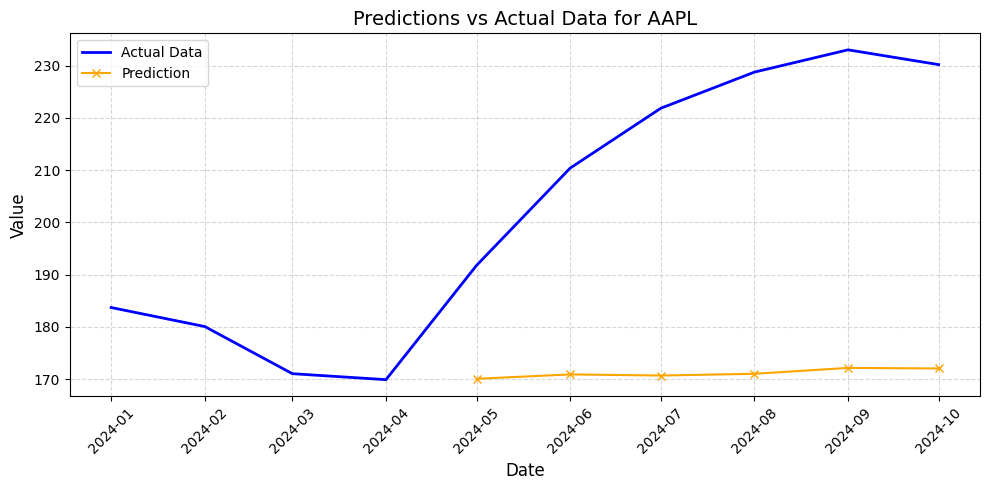

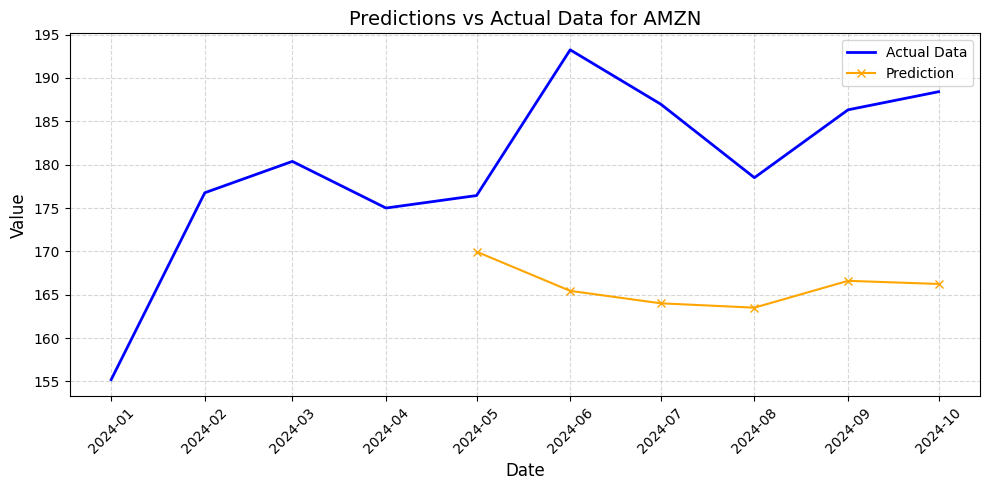

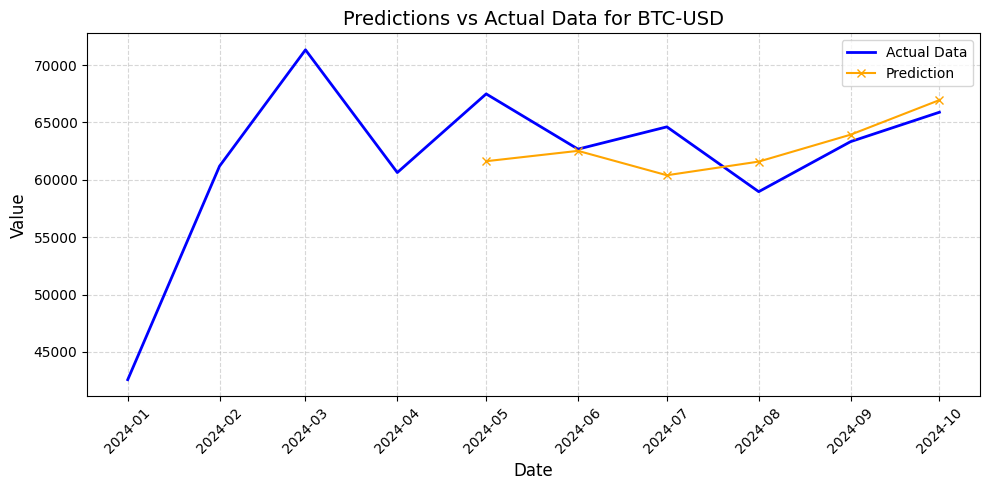

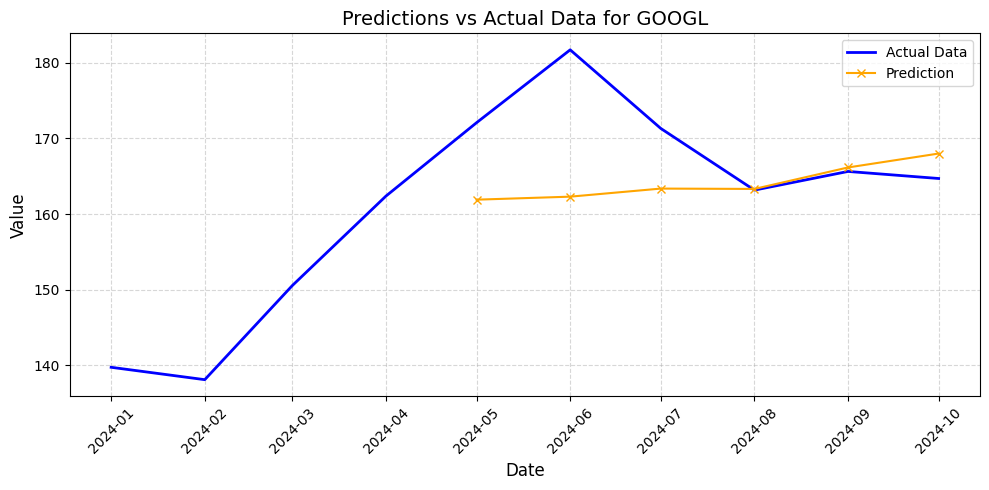

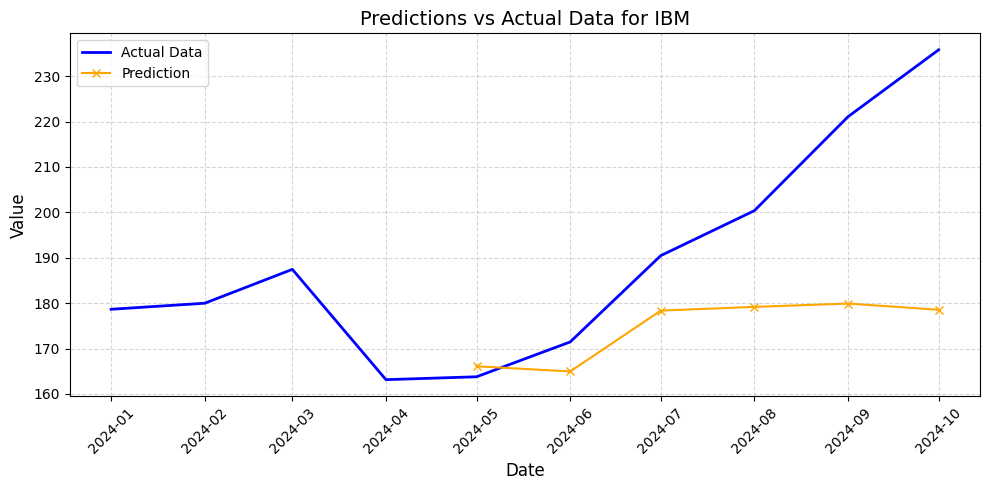

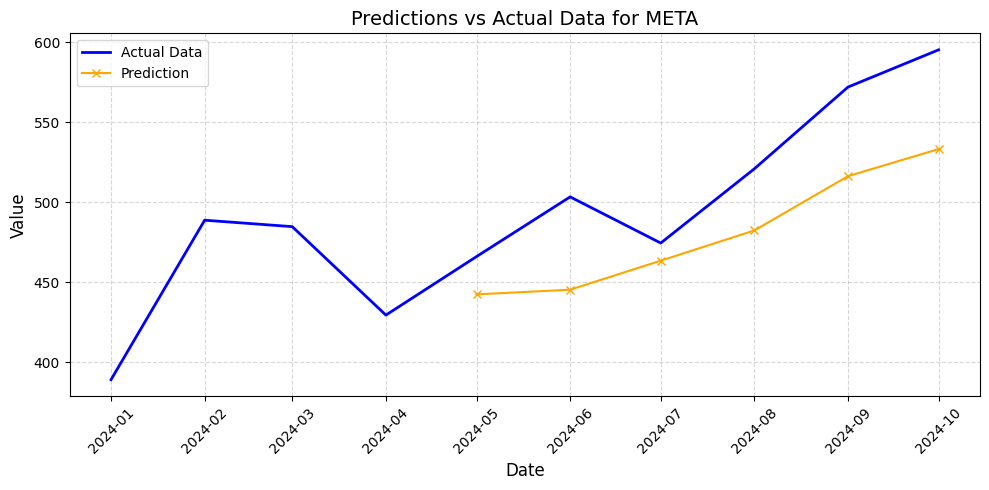

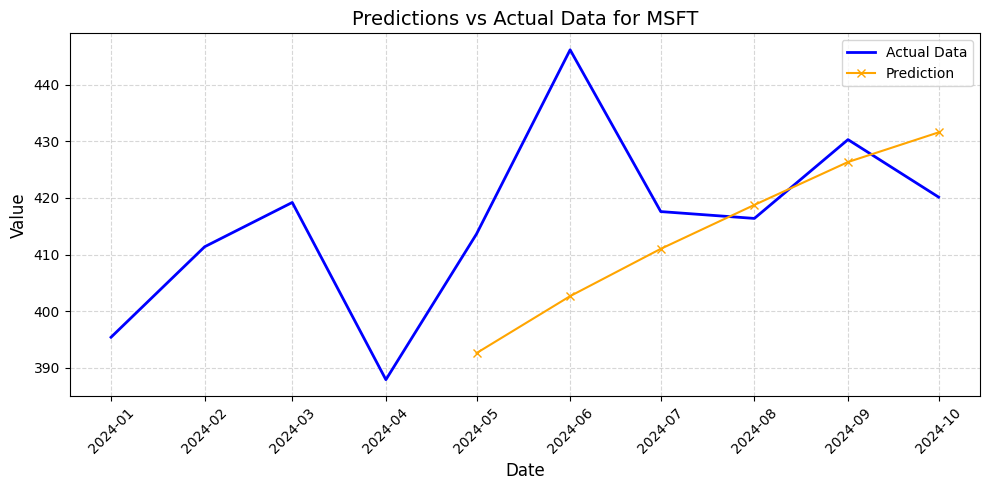

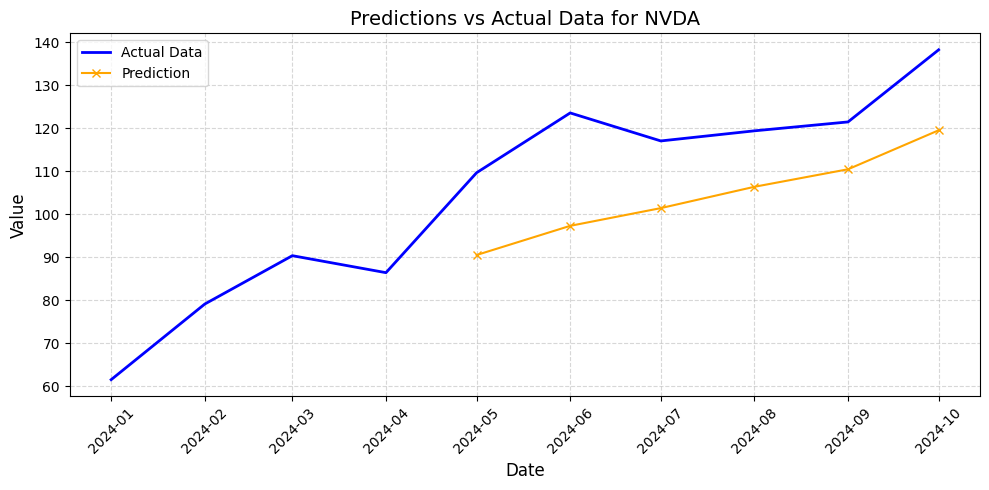

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the cutoff date
cutoff_date = '2024-01-01'

# Plotting predictions for each time series
for ticker in all_forecast_df['unique_id'].unique():
    plt.figure(figsize=(10, 5))

    # Filter predictions and actual data by ticker
    forecast_data = all_forecast_df[all_forecast_df['unique_id'] == ticker]
    actual_data = Y_df[Y_df['unique_id'] == ticker]

    # Filter data by the cutoff date
    forecast_data = forecast_data[forecast_data['ds'] >= cutoff_date]
    actual_data = actual_data[actual_data['ds'] >= cutoff_date]

    # Plot actual data as a solid line
    plt.plot(actual_data['ds'], actual_data['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Plot predictions as a dashed line
    plt.plot(forecast_data['ds'], forecast_data['PatchTST'], label='Prediction', marker='x', color='orange')

    # Configure the plot
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)

    # Set x-axis major locator and formatter for monthly ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set interval for months (e.g., every 3 months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.show()
